In [10]:
from datasets import load_dataset
import os
import torch
import torch.optim as optim
from utils.hybrid_model import *
from utils.hybrid_utils import *
from utils.utils import *

# Data preparation

In [11]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [12]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [13]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

Dataloaders

In [14]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [15]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Model

In [16]:
model = CNNRNNHybridModel(
    embed_dim=350,  # Embedding dimension, matching Word2vec or GloVe
    rnn_hidden_dim=128,
    num_classes= 1, # Binary classification
    kernel_size= 3, # Size of the kernel for the CNN layer
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
)

In [17]:
# Train and validate the model
train_losses, val_accuracies = train_hybrid_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=torch.optim.Adam(model.parameters(), lr=0.0001),
    criterion=nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=5,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)


Epoch 1/100, Loss: 0.6934
Accuracy: 0.5056
Validation Accuracy: 0.5056
Model saved.
Epoch 2/100, Loss: 0.6913
Accuracy: 0.5281
Validation Accuracy: 0.5281
Model saved.
Epoch 3/100, Loss: 0.6746
Accuracy: 0.5994
Validation Accuracy: 0.5994
Model saved.
Epoch 4/100, Loss: 0.5795
Accuracy: 0.6876
Validation Accuracy: 0.6876
Model saved.
Epoch 5/100, Loss: 0.4404
Accuracy: 0.6923
Validation Accuracy: 0.6923
Model saved.
Epoch 6/100, Loss: 0.3298
Accuracy: 0.6876
Validation Accuracy: 0.6876
Epoch 7/100, Loss: 0.2510
Accuracy: 0.6848
Validation Accuracy: 0.6848
Epoch 8/100, Loss: 0.2025
Accuracy: 0.6801
Validation Accuracy: 0.6801
Epoch 9/100, Loss: 0.1516
Accuracy: 0.6820
Validation Accuracy: 0.6820
Epoch 10/100, Loss: 0.1197
Accuracy: 0.6876
Validation Accuracy: 0.6876
Early stopping triggered.
Loading the best model from saved checkpoint...
Model loaded.


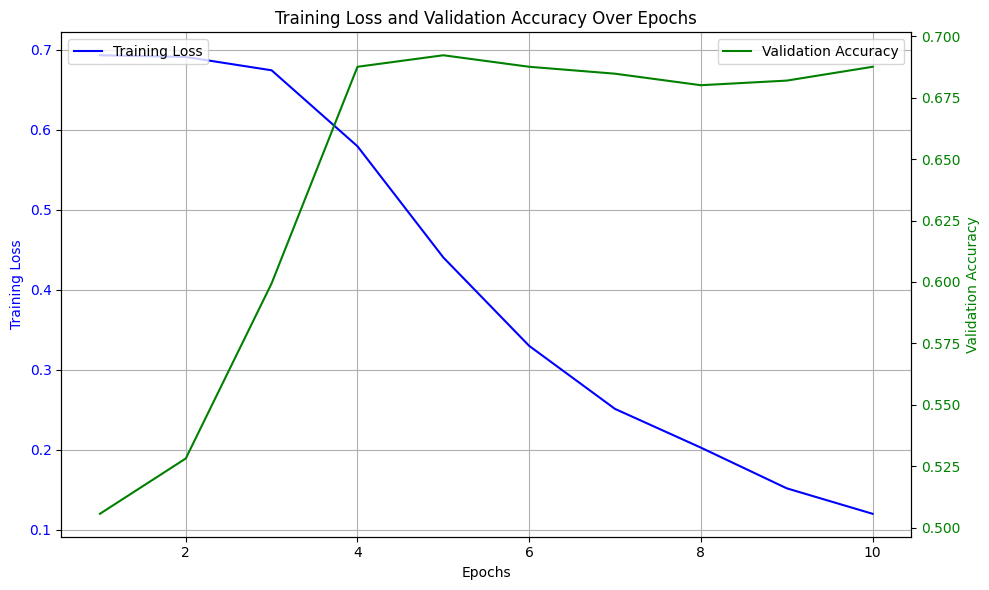

In [18]:
plot_training_progress(train_losses, val_accuracies)